<a href="https://colab.research.google.com/github/ishandahal/Fun_Projects/blob/master/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
pip install fastai -U

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.10)


In [47]:
from fastai.vision.all import *

In [48]:
path = untar_data(URLs.PETS)
path

Path('.')

In [49]:
Path.BASE_PATH = path

In [50]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [51]:
(path / 'images').ls()

(#7393) [Path('images/american_bulldog_180.jpg'),Path('images/Abyssinian_13.jpg'),Path('images/yorkshire_terrier_183.jpg'),Path('images/chihuahua_13.jpg'),Path('images/scottish_terrier_71.jpg'),Path('images/British_Shorthair_126.jpg'),Path('images/basset_hound_135.jpg'),Path('images/saint_bernard_182.jpg'),Path('images/pug_149.jpg'),Path('images/english_cocker_spaniel_3.jpg')...]

In [52]:
fname = (path / 'images').ls()[0]

In [53]:
fname

Path('images/american_bulldog_180.jpg')

In [54]:
re.findall(r"(\w+)_\d+.jpg$", fname.name)

['american_bulldog']

In [55]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 get_y=using_attr(RegexLabeller(r"(\w+)_.+g$"), 'name'),
                 splitter=RandomSplitter(),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path / 'images')

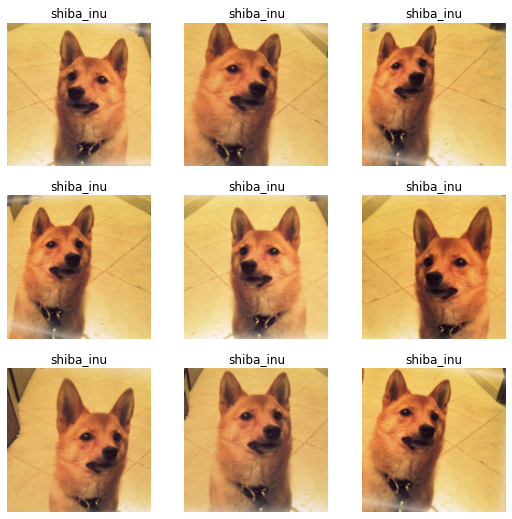

In [56]:
dls.show_batch(unique=True)

In [57]:
pets.summary(path)

Setting-up type transforms pipelines
Found 14780 items
2 datasets of sizes 11824,2956
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/annotations/trimaps/beagle_131.png
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/annotations/trimaps/beagle_131.png
    applying partial gives
      beagle
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(15)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(15))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pip

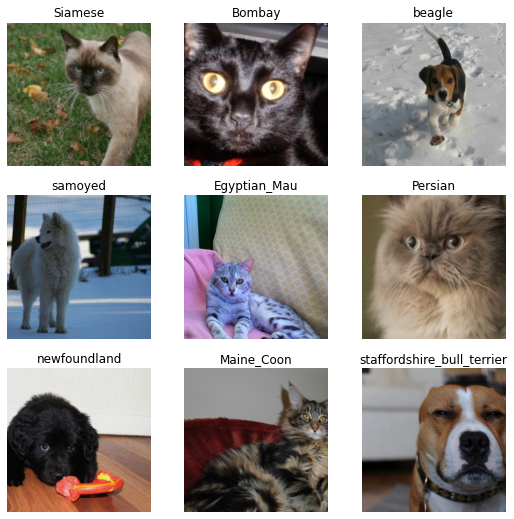

In [58]:
dls.show_batch()

In [59]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.572108,0.331676,0.102165,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.513145,0.307765,0.092016,01:10
1,0.313328,0.224944,0.068336,01:10


In [60]:
x,y = dls.one_batch()

In [61]:
y

TensorCategory([12, 28, 12, 34, 18, 23,  7,  5, 29, 25, 17,  3, 11, 23, 16, 14,  9,  4,
        29, 35, 14, 31, 28, 18,  4, 27,  7, 19, 20, 22, 23, 26, 36,  7,  1,  1,
        11, 28,  0,  4, 31, 25, 21, 14,  3, 14, 13,  5, 21,  3, 34,  8,  2, 22,
         9, 16, 30, 21,  7, 24, 22, 30, 29, 24], device='cuda:0')

In [62]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.9485e-05, 5.8925e-05, 9.1330e-06, 3.6601e-06, 3.1375e-05, 5.5626e-06,
        9.5841e-07, 4.0599e-06, 1.2053e-05, 7.5431e-05, 6.6017e-05, 1.7713e-03,
        7.6508e-01, 1.8794e-01, 6.1222e-04, 1.0866e-05, 2.1012e-03, 3.1901e-05,
        1.4924e-04, 1.1940e-03, 1.4962e-04, 4.0232e-04, 1.0575e-05, 1.0202e-05,
        2.3222e-04, 1.5294e-04, 1.6182e-05, 3.4070e-04, 7.1176e-06, 5.6638e-04,
        2.2999e-04, 1.3409e-04, 1.5029e-04, 7.1104e-05, 3.7468e-02, 8.0301e-04,
        7.5345e-05])

In [63]:
loss_func = nn.CrossEntropyLoss()

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

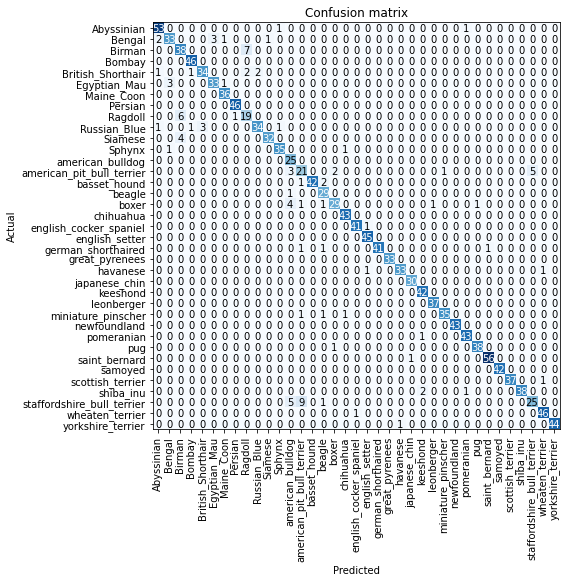

In [65]:
interp.plot_confusion_matrix(figsize=(8,8))

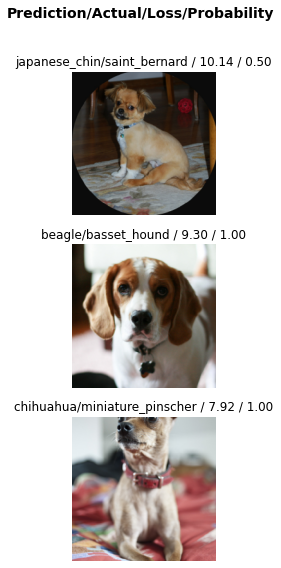

In [66]:
interp.plot_top_losses(3, nrows=3)

In [67]:
interp.most_confused(min_val=5)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 9),
 ('Birman', 'Ragdoll', 7),
 ('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

In [68]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.531459,4.117383,0.441813,01:07


epoch,train_loss,valid_loss,error_rate,time
0,3.371051,1.805385,0.541949,01:11


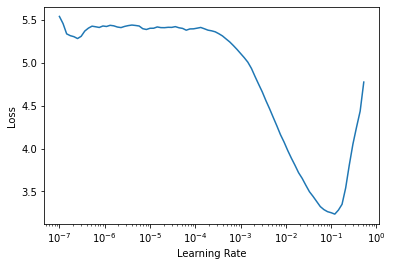

In [69]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [70]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 6.31e-03


In [71]:
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,4.887487,3.162371,0.848444,01:08
1,3.052028,1.202771,0.309878,01:08
2,1.820652,0.723713,0.197564,01:08
3,1.332488,0.580543,0.166441,01:08
4,1.132441,0.531128,0.150880,01:08
5,1.080135,0.530320,0.150203,01:08


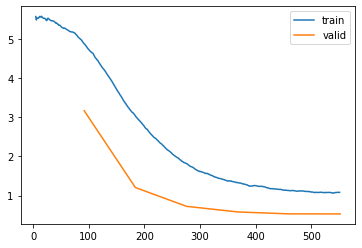

In [72]:
learn.recorder.plot_loss()

In [73]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.395751,0.299818,0.100812,01:10
1,0.601050,0.298751,0.093369,01:11
2,0.419868,0.264572,0.081867,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.274670,0.276272,0.081191,01:13
1,0.333692,0.430396,0.112314,01:13
2,0.259684,0.254950,0.072395,01:13
3,0.167877,0.259455,0.073072,01:13
4,0.085918,0.204054,0.054804,01:13
5,0.058542,0.182421,0.050744,01:12


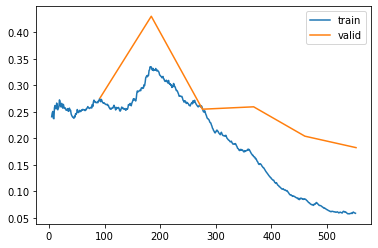

In [74]:
learn.recorder.plot_loss()